In [1]:
# Data imports
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import LabelBinarizer
import os
import matplotlib.pyplot as plt

In [2]:
# Load Data
image_paths = glob.glob('c:/Users/USER/Downloads/metalds/images/images/*/*.jpg')
image_paths = [os.path.normpath(path) for path in image_paths]


In [3]:
# Labels names
names = [x.split("\\")[-2] for x in image_paths]
names = pd.DataFrame(names, columns=['Types'])


In [4]:
# onehot for mutiple classes
from sklearn.preprocessing import LabelBinarizer

Class = names['Types'].unique()
Class_dict = dict(zip(Class, range(1,len(Class)+1)))
names['str'] = names['Types'].apply(lambda x: Class_dict[x])
lb = LabelBinarizer()
lb.fit(list(Class_dict.values()))
transformed_labels = lb.transform(names['str'])
y_bin_labels = []  

for i in range(transformed_labels.shape[1]):
    y_bin_labels.append('str' + str(i))
    names['str' + str(i)] = transformed_labels[:, i]

In [5]:
int(len(Class))

10

In [6]:
# Define load_image function
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, 3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image / 127.5 - 1, tf.float32)
    return image

In [7]:
# Create a Tensorflow dataset with only image and class label. NOTE: This will yield to an image-label pairing.
classification_dataset = tf.data.Dataset.from_tensor_slices((image_paths, transformed_labels))
classification_dataset = classification_dataset.map(lambda img, lbl: (load_image(img), lbl))

# Batch constant
BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE

# Batch and prefetch
classification_dataset = classification_dataset.repeat().shuffle(500).batch(BATCH_SIZE)
classification_dataset = classification_dataset.prefetch(AUTO)

# Split dataset
test_count = int(len(image_paths) * 0.2)
train_count = len(image_paths) - test_count

train_dataset = classification_dataset.skip(test_count)
test_dataset = classification_dataset.take(test_count)


In [8]:
species_dict = {v:k for k,v in Class_dict.items()}

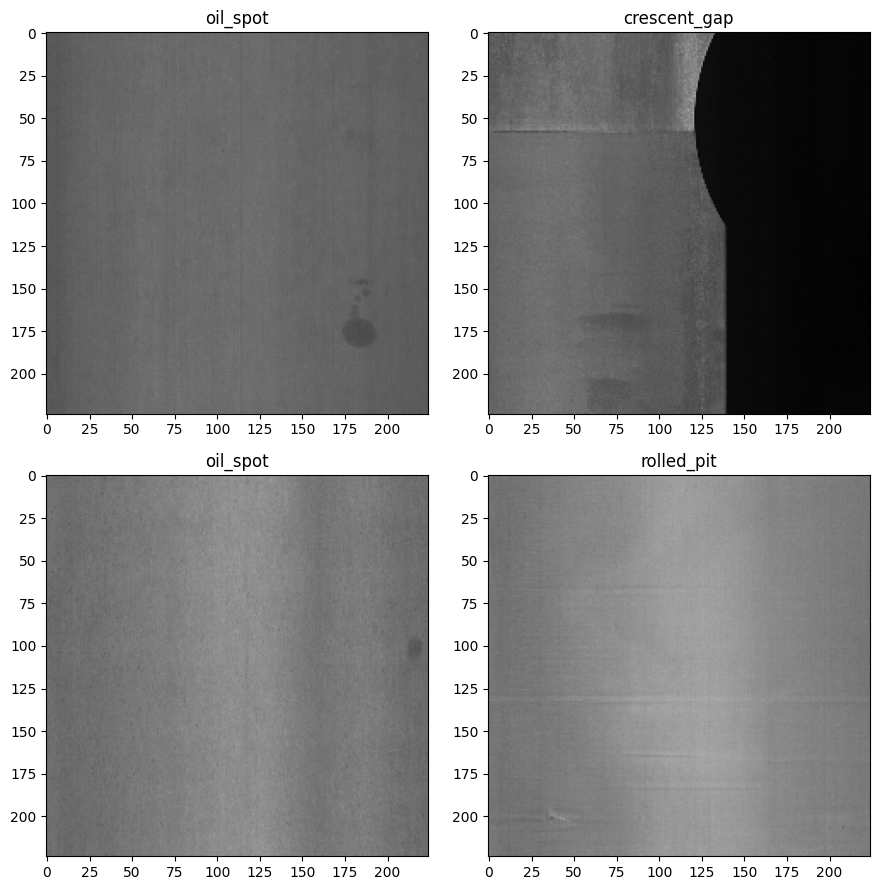

In [13]:
# Take one batch from the training dataset
for images, labels in train_dataset.take(1):
    images = images.numpy()
    labels = labels.numpy()

# Plot the images
fig, axes = plt.subplots(2, 2, figsize=(9, 9))
axes = axes.flatten()

for img, lbl, ax in zip(images[:5], labels[:5], axes):
    ax.imshow((img + 1) / 2)  # Rescale the image from [-1, 1] to [0, 1]
    
    # Get label index and convert it to corresponding class name
    label_index = np.argmax(lbl)
    label_name = species_dict[label_index + 1] 
    
    ax.set_title(label_name)
    ax.axis('on')  

plt.tight_layout()
plt.show()


In [10]:
# Model architecture
conv = keras.applications.xception.Xception(weights='imagenet',
                                            include_top=False,
                                            input_shape=(224, 224, 3),
                                            pooling='avg')

# Define only the classification part of the model
inputs = keras.Input(shape=(224, 224, 3))
x = conv(inputs)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)
out_class = keras.layers.Dense(10, activation='softmax', name='out_item')(x)

# Create the model
classification_model = keras.models.Model(inputs=inputs, outputs=out_class)
classification_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 out_item (Dense)            (None, 10)                5130      
                                                                 
Total params: 23,489,586
Trainable params: 23,435,058
Non-tra

In [11]:
# Compile the model
classification_model.compile(optimizer=keras.optimizers.Adam(0.0003),
                             loss='categorical_crossentropy',
                             metrics=['acc'])

In [12]:
# Training
history = classification_model.fit(train_dataset,
                                   steps_per_epoch=train_count // BATCH_SIZE,
                                   epochs=50,
                                   validation_data=test_dataset,
                                   validation_steps=test_count // BATCH_SIZE)

Epoch 1/50
115/115 [==============================] - 40s 152ms/step - loss: 1.2615 - acc: 0.6326 - val_loss: 5.4572 - val_acc: 0.3371
Epoch 2/50
115/115 [==============================] - 17s 147ms/step - loss: 0.8207 - acc: 0.7723 - val_loss: 3.9485 - val_acc: 0.1473
Epoch 3/50
115/115 [==============================] - 17s 148ms/step - loss: 0.7183 - acc: 0.7957 - val_loss: 1.2204 - val_acc: 0.7165
Epoch 4/50
115/115 [==============================] - 17s 149ms/step - loss: 0.6867 - acc: 0.8158 - val_loss: 0.4938 - val_acc: 0.8750
Epoch 5/50
115/115 [==============================] - 17s 149ms/step - loss: 0.5754 - acc: 0.8386 - val_loss: 0.4922 - val_acc: 0.8750
Epoch 6/50
115/115 [==============================] - 17s 148ms/step - loss: 0.3702 - acc: 0.8984 - val_loss: 1.0010 - val_acc: 0.7545
Epoch 7/50
115/115 [==============================] - 17s 149ms/step - loss: 0.4017 - acc: 0.8853 - val_loss: 3.6254 - val_acc: 0.5357
Epoch 8/50
115/115 [==============================] - 1